In [ ]:
import json
from collections import defaultdict
from pathlib import Path
import shutil
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt

In [2]:
SHIPS_CLASSES = {
    "Other Ship": 1,
    "Warship": 2,
    "Merchant": 3,
    "Dock": 4,
}

SHIPS_CLASSES_REVERSED = {v: k for k, v in SHIPS_CLASSES.items()}

In [ ]:
ships_val_labels = "D:\\stuff\\datasets\\ShipRSImageNet\\annotations\\ShipRSImageNet_bbox_val_level_1.json"
ships_train_labels = "D:\\stuff\\datasets\\ShipRSImageNet\\annotations\\ShipRSImageNet_bbox_train_level_1.json"

def load_and_prepare_coco_data(json_path):
    with open(json_path) as f:
        data = json.load(f)

    image_id_to_filename = {image["id"]: image["file_name"] for image in data["images"]}
    annotations_by_filename = defaultdict(list)

    for ann in data["annotations"]:
        image_id = ann["image_id"]
        if image_id in image_id_to_filename:
            filename = image_id_to_filename[image_id]
            annotations_by_filename[filename].append(ann)

    return annotations_by_filename


def show_image_with_boxes_ships(image_path, object_name=None):
    print(f"Showing: {image_path}")
    val_data = load_and_prepare_coco_data(ships_val_labels)
    train_data = load_and_prepare_coco_data(ships_train_labels)
    all_annotations = {**val_data, **train_data}

    image_filename = Path(image_path).name
    annotations_for_this_image = all_annotations.get(image_filename, [])

    img = cv2.imread(str(image_path))

    for ann in annotations_for_this_image:
        class_id = ann["category_id"]
        cls_name = SHIPS_CLASSES_REVERSED.get(class_id)

        if object_name is None or cls_name == object_name:
            x, y, w, h = [int(v) for v in ann["bbox"]]
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(img, cls_name, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

Showing: D:\stuff\datasets\ShipRSImageNet\images\000325.jpg


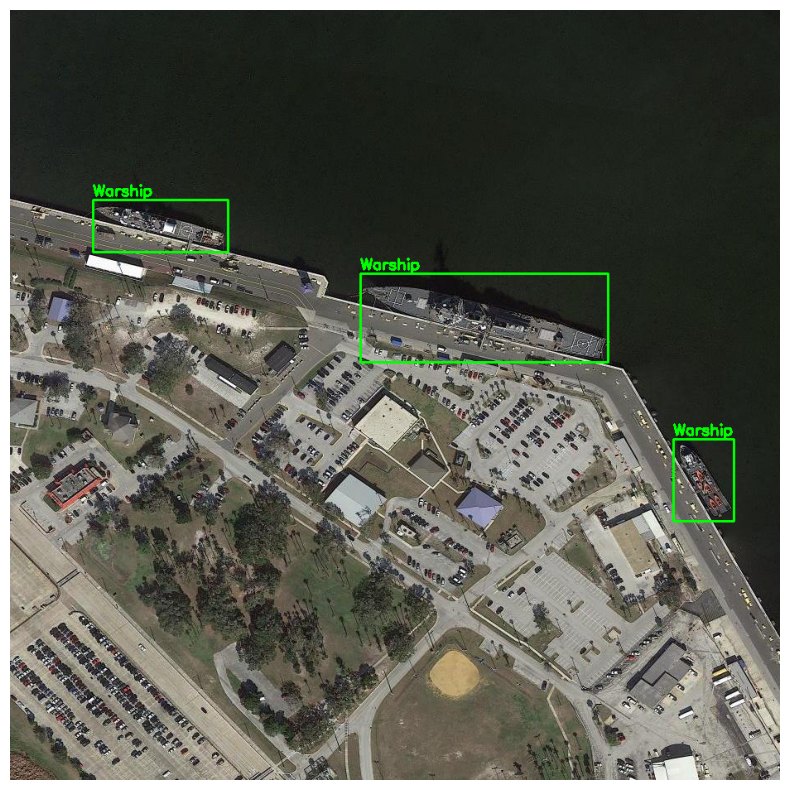

In [ ]:
image_path = "D:\\stuff\\datasets\\ShipRSImageNet\\images\\100000772.jpg"
show_image_with_boxes_ships(image_path) # , "Warship")

In [10]:
source_dir = Path("D:/stuff/datasets/DOTANA/DOTANA")
dest_dir = Path("D:/stuff/datasets/DOTANA/DOTANA_no_ships")
category_id_to_remove = 4

if dest_dir.exists():
    shutil.rmtree(dest_dir)

for split_dir in source_dir.iterdir():
    if not split_dir.is_dir():
        continue

    split = split_dir.name

    source_images_path = split_dir / "images"
    source_labels_path = split_dir / "labels"

    dest_split_path = dest_dir / split
    dest_images_path = dest_split_path / "images"
    dest_labels_path = dest_split_path / "labels"
    dest_images_path.mkdir(parents=True, exist_ok=True)
    dest_labels_path.mkdir(parents=True, exist_ok=True)

    label_files = list(source_labels_path.glob("*.txt"))

    for label_file in tqdm(label_files, desc=f"Processing {split}"):
        with open(label_file, 'r') as f:
            has_ship = any(
                line.strip().startswith(f"{category_id_to_remove}") for line in f
            )

        if not has_ship:
            shutil.copy(label_file, dest_labels_path)
            source_image = source_images_path / f"{label_file.stem}.jpg"
            shutil.copy(source_image, dest_images_path)



Processing valid: 100%|██████████| 3630/3630 [01:52<00:00, 32.25it/s] 
